In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from dataset import defectDataset_df, create_circular_mask, split_and_sample
import random
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import os
from grayscale_resnet import resnet18
from torchvision.models.resnet import BasicBlock, conv3x3, Bottleneck

In [2]:
window_size = 45
pad_size = window_size
classes = ["pos","neg","pos_o","nuc","non"]
batch_size = 256

In [3]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(200, scale=(1, 1), ratio=(1, 1)),
        transforms.RandomRotation((-90,90)),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
#         torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3019],
                             std=[0.1909])
    ])

In [4]:
trainset = defectDataset_df(df = split_and_sample(method = 'uniform',n_samples = 1995), window_size = window_size, transforms=data_transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=4)
print("trainloader ready!")

testset = defectDataset_df(df = split_and_sample(df_labels = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/test.csv', sep=" "),
                                                      method = 'uniform',n_samples = 500), window_size = window_size, transforms=data_transform)
testloader = torch.utils.data.DataLoader(testset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=4)
print("testloader ready!")

trainloader ready!
testloader ready!


In [5]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU in use")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classes = ["pos","neg","pos_o","nuc","non"]
num_of_classes = len(classes)

GPU in use


In [6]:
def imshow(img):
    img = img * 0.1909 + 0.3019     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

GroundTruth:    pos   pos   neg pos_o pos_o pos_o   non   pos
tensor([0, 0, 1, 2, 2, 2, 4, 0, 2, 4, 4, 3, 1, 1, 3, 4, 3, 4, 2, 0, 3, 4, 0, 4,
        1, 4, 3, 0, 0, 1, 1, 0, 3, 2, 3, 2, 3, 4, 4, 1, 2, 4, 0, 1, 3, 2, 0, 2,
        1, 3, 2, 0, 3, 1, 1, 1, 4, 4, 2, 4, 2, 0, 4, 3, 4, 3, 2, 2, 4, 4, 2, 2,
        0, 2, 0, 2, 3, 3, 0, 4, 4, 1, 1, 3, 1, 4, 1, 0, 1, 3, 0, 4, 0, 2, 3, 2,
        2, 0, 2, 1, 2, 0, 3, 0, 1, 0, 0, 3, 4, 4, 4, 2, 1, 3, 2, 2, 2, 4, 3, 1,
        1, 1, 3, 4, 0, 0, 1, 1, 3, 4, 4, 3, 2, 2, 2, 1, 0, 3, 0, 0, 3, 4, 3, 0,
        4, 0, 2, 3, 3, 1, 0, 1, 3, 3, 0, 4, 1, 1, 3, 2, 0, 1, 1, 4, 3, 4, 4, 0,
        1, 3, 1, 2, 2, 4, 2, 4, 1, 3, 4, 4, 4, 3, 4, 1, 0, 2, 1, 0, 1, 2, 0, 1,
        2, 0, 2, 2, 4, 1, 1, 4, 2, 0, 2, 1, 4, 3, 0, 0, 0, 4, 2, 0, 4, 1, 0, 1,
        3, 4, 0, 0, 0, 2, 3, 2, 3, 1, 3, 1, 4, 4, 1, 2, 1, 2, 0, 3, 2, 2, 3, 0,
        3, 4, 2, 2, 2, 1, 4, 0, 0, 3, 3, 2, 3, 2, 0, 2])


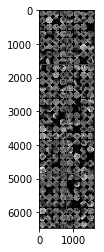

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
classes = ["pos","neg","pos_o","nuc","non"]
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))
print(labels)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training phase
        scheduler.step()
        model.train(True)  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        trainset = defectDataset_df(df = split_and_sample(method = 'uniform',n_samples = 1995), window_size = window_size, transforms=data_transform)
        trainloader = torch.utils.data.DataLoader(trainset,
                                                     batch_size=batch_size, shuffle=True,
                                                     num_workers=4)
        print("trainloader ready!")

        testset = defectDataset_df(df = split_and_sample(df_labels = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/test.csv', sep=" "),
                                                              method = 'uniform',n_samples = 500), window_size = window_size, transforms=data_transform)
        testloader = torch.utils.data.DataLoader(testset,
                                                     batch_size=batch_size, shuffle=True,
                                                     num_workers=4)
        print("testloader ready!")
        for data in trainloader:
            # get the inputs
            inputs, labels = data
#            print(inputs)
            # wrap them in Variable
            if use_gpu:
#                inputs = Variable(inputs.cuda())
#                labels = Variable(labels.cuda())
#                inputs = torch.nn.DataParallel(inputs, device_ids=[0, 1]).cuda()
#                labels = torch.nn.DataParallel(labels, device_ids=[0, 1]).cuda()
                inputs, labels = inputs.to(device), labels.to(device)
#                print(inputs)
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()


            m = nn.LogSoftmax(dim=0)
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(m(outputs), labels)
            # forward
#            outputs = model(inputs)
#            _, preds = torch.max(outputs.data, 1)
#            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # statistics
            iter_loss = loss.item()
            correct = torch.sum(preds == labels.data).item()
            batch_accuracy = correct / batch_size
            running_loss += loss.item()
            running_corrects_tensor = torch.sum(preds == labels.data)
            running_corrects += running_corrects_tensor.item()        
            epoch_loss = running_loss / len(trainset)
            epoch_acc = running_corrects / len(trainset)
            
            print('{} Loss: {:.4f} Acc: {:.4f} batch_loss: {:.4f} correct: {:d} batch_accuracy: {:.4f}'.format(
                "train", epoch_loss, epoch_acc, iter_loss, correct, batch_accuracy))
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
#                print('processed: %d' % total)
#                print('correct: %d' % correct)
        print('Accuracy of the network on the test images: %.5f %%' % (
            100 * correct / total))
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:

# transfer learning resnet18
model_ft = resnet18()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_of_classes)

if use_gpu:
    model_ft = torch.nn.DataParallel(model_ft)
    model_ft.to(device)

criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001,  momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.1)

# train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)
torch.save(model_ft, output_path)



Epoch 0/9
----------
trainloader ready!
testloader ready!
train Loss: 0.0006 Acc: 0.0062 batch_loss: 5.5480 correct: 62 batch_accuracy: 0.2422
train Loss: 0.0011 Acc: 0.0113 batch_loss: 5.5304 correct: 51 batch_accuracy: 0.1992
train Loss: 0.0017 Acc: 0.0178 batch_loss: 5.5259 correct: 65 batch_accuracy: 0.2539
train Loss: 0.0022 Acc: 0.0226 batch_loss: 5.5229 correct: 47 batch_accuracy: 0.1836
train Loss: 0.0028 Acc: 0.0285 batch_loss: 5.5059 correct: 59 batch_accuracy: 0.2305
train Loss: 0.0033 Acc: 0.0325 batch_loss: 5.5166 correct: 40 batch_accuracy: 0.1562
train Loss: 0.0039 Acc: 0.0390 batch_loss: 5.4879 correct: 65 batch_accuracy: 0.2539
train Loss: 0.0044 Acc: 0.0440 batch_loss: 5.5079 correct: 50 batch_accuracy: 0.1953
train Loss: 0.0050 Acc: 0.0505 batch_loss: 5.4820 correct: 65 batch_accuracy: 0.2539
train Loss: 0.0055 Acc: 0.0576 batch_loss: 5.4693 correct: 71 batch_accuracy: 0.2773
train Loss: 0.0061 Acc: 0.0638 batch_loss: 5.4956 correct: 61 batch_accuracy: 0.2383
train L

KeyboardInterrupt: 